# DSCI 573 - Feature and Model Selection

# Lab 4: A mini project - Putting it all together

## Table of contents
0. [Submission instructions](#si) (4%)
1. [Understanding the problem](#1) (4%)
2. [Data splitting](#2) (2%)
3. [EDA](#3) (10%)
4. (Optional) [Feature engineering](#4)
5. [Preprocessing and transformations](#5) (10%)
6. [Baseline model](#6) (2%)
7. [Linear models](#7) (10%)
8. [Different models](#8) (16%)
9. (Optional) [Feature selection](#9)
10. [Hyperparameter optimization](#10) (10%)
11. [Interpretation and feature importances](#11) (10%)
12. [Results on the test set](#12) (10%)
13. [Summary of the results](#13) (12%)
15. (Optional) [Reproducible data analysis pipeline](#14)
15. (Optional) [Your takeaway from the course](#15)

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:4}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Which problem did you pick, classification or regression? Classification**
- **Report your test score here along with the metric used: F1 Score: 0.543** 
- **Please add a link to your GitHub repository here: https://github.ubc.ca/mds-2021-22/DSCI_573_lab4_rubendlg**
- **You don't have to but you may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. Since I don't know your groups in advance, I am not opening this lab as a group lab. So you all will have a separate GitHub repository for your labs and you'll have to decide how you want to collaborate. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb. 
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

> As usual, do not push the data to the repository. 

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz

%matplotlib inline

from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server');

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.svm import SVC
import eli5
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import shap

## Introduction <a name="in"></a>

In this lab you will be working on an open-ended mini-project, where you will put all the different things you have learned so far in 571 and 573 together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Pick your problem and explain what exactly you are trying to predict <a name="1"></a>
<hr>
rubric={reasoning:4}

In this mini project, you will pick one of the following problems: 

- A classification problem of predicting whether a credit card client will default or not. For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

OR 

- A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed (e.g., changing feature names, handling of NaN values etc.)

In [2]:
#Read data
credit_card_df = pd.read_csv("UCI_Credit_Card.csv")

#Rename columns
credit_card_df = credit_card_df.rename(str.lower, axis='columns')
credit_card_df = credit_card_df.rename(columns={"pay_0": "pay_1", "default.payment.next.month": "default_payment"})

#Reset index
credit_card_df

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


Initial thoughts are that there is bad documentation and lots of values that have not been explained but are showing up in the data. There are also lots of unknown categories and other categories that are not that useful but we must keep in the data as they still may contain information that may be helpful. We changed the name of the columns to make it more to our preference and make it easier to understand.

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={reasoning:2}

**Your tasks:**

1. Split the data into train and test portions.

> Make decision on the `test_size` based on the capacity of your laptop. Don't forget to use a random state.  

In [3]:
train_df, test_df = train_test_split(credit_card_df, train_size=0.5, random_state=573)
X_train = train_df.drop(columns=['default_payment'])
y_train = train_df['default_payment']
X_test = test_df.drop(columns=['default_payment'])
y_test = test_df['default_payment']

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={viz:4,reasoning:6}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

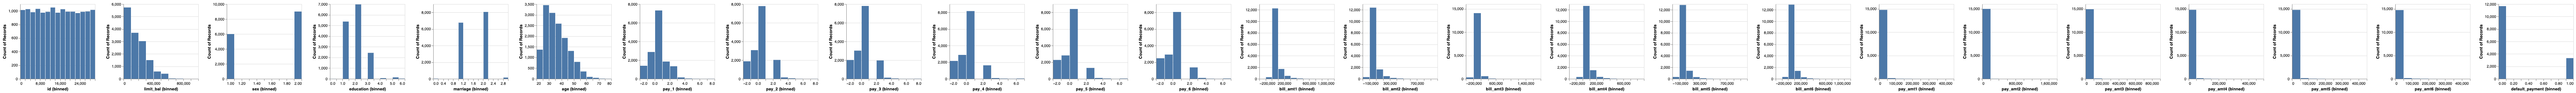

In [4]:
train_df_yn = train_df.copy()
train_df_yn["default_payment"].replace({1: 'yes'}, inplace=True)
train_df_yn["default_payment"].replace({0: 'no'}, inplace=True)

alt.Chart(train_df).mark_bar().encode(
    x=alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=15)),
    y='count()'
).properties(
    width=200,
    height=200
).repeat(
    credit_card_df.columns.tolist()
)

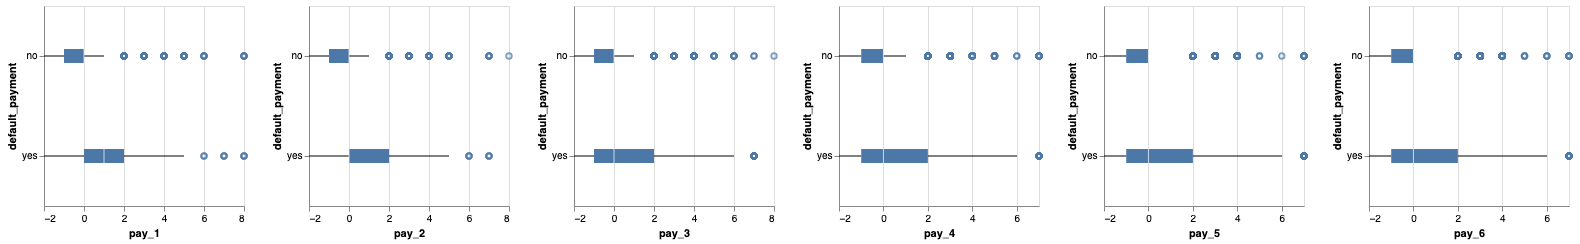

In [5]:
(alt.Chart(train_df_yn).mark_boxplot().encode(
    x=alt.X(alt.repeat('column'), type='quantitative'),
    y=alt.Y(alt.repeat('row'), type='nominal')
).properties(
    width=200,
    height=200
).repeat(
    column=['pay_1','pay_2','pay_3','pay_4','pay_5','pay_6'],
    row=['default_payment']
))

# Use one just for the pay_x vs target
# Use one just for limit_bal vs target

We found that for most people that defaulted they were a lot more behind on their payments then people who did not default. We see this by looking at the median value in our box plots above. For example, in the case of pay_1 we see that the median of the people that defaulted is 1 and the median of the people that didn’t is 0.

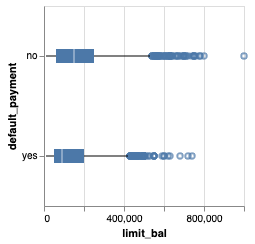

In [6]:
(alt.Chart(train_df_yn).mark_boxplot().encode(
    x=alt.X(alt.repeat('row'), type='quantitative'),
    y=alt.Y(alt.repeat('column'), type='nominal')
).properties(
    width=200,
    height=200
).repeat(
    row=['limit_bal'],
    column=['default_payment']
))

We found that people who defaulted have a smaller limit balance than people who do not default and we see this in our box plot above that shows distribution of limit balance vs the target when we look at where the median is plotted. For example, in the case of limit_bal we see that the median of the people that defaulted is 90,000 and the median of the people that didn’t is 150,000.

In [7]:
scoring_metrics = [
    "accuracy",
    "f1",
    "recall",
    "precision"
]

For scoring metric we would like to use accuracy, precision, recall and f1 we feel as for our problem all of these are strong metric to take a look at but we feel as though since we aren’t trying to minimize something specific we will value f1 the highest.

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [8]:
drop_features = ["id", "sex"]
categorical_features = ["marriage", "education"]
numeric_features = ["limit_bal",
                    "age",
                    "pay_1", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6",
                    "bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6",
                    "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]
target = "default_payment"

preprocessor = make_column_transformer(
    (
        StandardScaler(), numeric_features
    ),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False), 
        categorical_features,
    ),
    ("drop", drop_features)
)


<br><br>

## 6. Baseline model <a name="6"></a>
<hr>
rubric={accuracy:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [9]:
#Taken from past labs
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [10]:
results={}

In [11]:
pipe_dummy = make_pipeline(preprocessor, DummyClassifier())

results["DummyClassifier"] = mean_std_cross_val_scores(pipe_dummy, 
                                                       X_train, 
                                                       y_train, 
                                                       return_train_score=True, 
                                                       scoring=scoring_metrics)

pd.DataFrame(results)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

,DummyClassifier
fit_time,0.033 (+/- 0.012)
score_time,0.042 (+/- 0.027)
test_accuracy,0.778 (+/- 0.000)
train_accuracy,0.778 (+/- 0.000)
test_f1,0.000 (+/- 0.000)
train_f1,0.000 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
train_recall,0.000 (+/- 0.000)
test_precision,0.000 (+/- 0.000)
train_precision,0.000 (+/- 0.000)


<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

In [12]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

results["LogisticRegression"] = mean_std_cross_val_scores(pipe_lr, 
                                                       X_train, 
                                                       y_train, 
                                                       return_train_score=True, 
                                                       scoring=scoring_metrics)

pd.DataFrame(results)

,DummyClassifier,LogisticRegression
fit_time,0.033 (+/- 0.012),0.768 (+/- 0.118)
score_time,0.042 (+/- 0.027),0.026 (+/- 0.009)
test_accuracy,0.778 (+/- 0.000),0.809 (+/- 0.005)
train_accuracy,0.778 (+/- 0.000),0.811 (+/- 0.001)
test_f1,0.000 (+/- 0.000),0.351 (+/- 0.018)
train_f1,0.000 (+/- 0.000),0.360 (+/- 0.011)
test_recall,0.000 (+/- 0.000),0.233 (+/- 0.012)
train_recall,0.000 (+/- 0.000),0.240 (+/- 0.010)
test_precision,0.000 (+/- 0.000),0.708 (+/- 0.034)
train_precision,0.000 (+/- 0.000),0.717 (+/- 0.004)


In [13]:
param_grid = {
    "logisticregression__C": 10.0 ** np.arange(-4, 6, 1), 
    "logisticregression__class_weight": [None, 'balanced']
}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_grid,
    n_jobs=-1,
    n_iter=10,
    cv=5,
    random_state=573,
    scoring=scoring_metrics,
    refit="f1"
)

random_search.fit(X_train, y_train);

In [14]:
print("The results for the hyperparameter optimization are the following:")
pd.DataFrame(random_search.cv_results_).sort_values(by='rank_test_f1').T

The results for the hyperparameter optimization are the following:


,8,0,2,1,9,6,4,5,3,7
mean_fit_time,0.240905,0.803481,1.6386,2.386134,1.879012,0.116027,2.043176,1.874794,0.310385,0.120388
std_fit_time,0.013493,0.124186,0.144501,0.43018,0.473657,0.016529,0.454824,0.472051,0.06045,0.015894
mean_score_time,0.031612,0.052644,0.057336,0.041428,0.054163,0.032155,0.046677,0.040428,0.058152,0.030848
std_score_time,0.008317,0.019442,0.01128,0.00975,0.01705,0.005401,0.012136,0.013148,0.007979,0.003617
param_logisticregression__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,None,None,None,None
param_logisticregression__C,0.01,0.1,1.0,1000.0,100000.0,0.0001,100.0,10.0,0.01,0.001
params,{'logisticregression__class_weight': 'balanced...,{'logisticregression__class_weight': 'balanced...,{'logisticregression__class_weight': 'balanced...,{'logisticregression__class_weight': 'balanced...,{'logisticregression__class_weight': 'balanced...,{'logisticregression__class_weight': 'balanced...,"{'logisticregression__class_weight': None, 'lo...","{'logisticregression__class_weight': None, 'lo...","{'logisticregression__class_weight': None, 'lo...","{'logisticregression__class_weight': None, 'lo..."
split0_test_accuracy,0.698333,0.694667,0.692333,0.691667,0.691,0.665667,0.805,0.805,0.802,0.796333
split1_test_accuracy,0.707333,0.702,0.698333,0.698333,0.698333,0.669333,0.805333,0.804333,0.804667,0.797
split2_test_accuracy,0.675667,0.671667,0.666333,0.664667,0.664667,0.669,0.806667,0.806333,0.804333,0.797667


In [15]:
print("The best parameters are the following:")
random_search.best_params_

The best parameters are the following:


{'logisticregression__class_weight': 'balanced', 'logisticregression__C': 0.01}

In [16]:
pipe_lr_opt = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, 
                                                             C=random_search.best_params_['logisticregression__C'], 
                                                             class_weight=random_search.best_params_['logisticregression__class_weight']))

results["LogisticRegressionOpt"] = mean_std_cross_val_scores(pipe_lr_opt, 
                                                       X_train, 
                                                       y_train, 
                                                       return_train_score=True, 
                                                       scoring=scoring_metrics)

pd.DataFrame(results)

,DummyClassifier,LogisticRegression,LogisticRegressionOpt
fit_time,0.033 (+/- 0.012),0.768 (+/- 0.118),0.220 (+/- 0.039)
score_time,0.042 (+/- 0.027),0.026 (+/- 0.009),0.032 (+/- 0.013)
test_accuracy,0.778 (+/- 0.000),0.809 (+/- 0.005),0.691 (+/- 0.013)
train_accuracy,0.778 (+/- 0.000),0.811 (+/- 0.001),0.692 (+/- 0.007)
test_f1,0.000 (+/- 0.000),0.351 (+/- 0.018),0.477 (+/- 0.016)
train_f1,0.000 (+/- 0.000),0.360 (+/- 0.011),0.478 (+/- 0.005)
test_recall,0.000 (+/- 0.000),0.233 (+/- 0.012),0.635 (+/- 0.018)
train_recall,0.000 (+/- 0.000),0.240 (+/- 0.010),0.637 (+/- 0.009)
test_precision,0.000 (+/- 0.000),0.708 (+/- 0.034),0.382 (+/- 0.015)
train_precision,0.000 (+/- 0.000),0.717 (+/- 0.004),0.383 (+/- 0.006)


We found the validation f1 to be 0.35 and we see very little overfitting since the training score is very close to the validation score. This is a decent start. Then we preformed tuning and found a good C value to use is 0.01 and to use class_weight = ‘balanced’  and then the validation f1 became 0.47 with also very little overfitting.

<br><br>

## 8. Different models <a name="8"></a>
<hr>
rubric={accuracy:10,reasoning:6}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

In [17]:
models = {
    "RandomForestClassifier": make_pipeline(preprocessor, RandomForestClassifier(random_state=573, class_weight='balanced')),
    "CatBoostClassifier": make_pipeline(preprocessor, CatBoostClassifier(random_state=573, verbose=0, class_weights=[0.25, 0.75])),
    "SVC": make_pipeline(preprocessor, SVC(random_state=573, class_weight='balanced'))
}

for name, pipe in models.items():
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    );

In [18]:
pd.DataFrame(results)

,DummyClassifier,LogisticRegression,LogisticRegressionOpt,RandomForestClassifier,CatBoostClassifier,SVC
fit_time,0.033 (+/- 0.012),0.768 (+/- 0.118),0.220 (+/- 0.039),4.077 (+/- 0.583),9.541 (+/- 0.969),16.756 (+/- 1.276)
score_time,0.042 (+/- 0.027),0.026 (+/- 0.009),0.032 (+/- 0.013),0.154 (+/- 0.026),0.053 (+/- 0.006),6.358 (+/- 0.334)
test_accuracy,0.778 (+/- 0.000),0.809 (+/- 0.005),0.691 (+/- 0.013),0.810 (+/- 0.006),0.783 (+/- 0.008),0.777 (+/- 0.007)
train_accuracy,0.778 (+/- 0.000),0.811 (+/- 0.001),0.692 (+/- 0.007),1.000 (+/- 0.000),0.865 (+/- 0.003),0.789 (+/- 0.003)
test_f1,0.000 (+/- 0.000),0.351 (+/- 0.018),0.477 (+/- 0.016),0.436 (+/- 0.017),0.536 (+/- 0.016),0.535 (+/- 0.011)
train_f1,0.000 (+/- 0.000),0.360 (+/- 0.011),0.478 (+/- 0.005),0.999 (+/- 0.000),0.722 (+/- 0.006),0.563 (+/- 0.003)
test_recall,0.000 (+/- 0.000),0.233 (+/- 0.012),0.635 (+/- 0.018),0.331 (+/- 0.012),0.565 (+/- 0.019),0.579 (+/- 0.012)
train_recall,0.000 (+/- 0.000),0.240 (+/- 0.010),0.637 (+/- 0.009),1.000 (+/- 0.000),0.792 (+/- 0.007),0.611 (+/- 0.008)
test_precision,0.000 (+/- 0.000),0.708 (+/- 0.034),0.382 (+/- 0.015),0.640 (+/- 0.030),0.510 (+/- 0.016),0.497 (+/- 0.013)
train_precision,0.000 (+/- 0.000),0.717 (+/- 0.004),0.383 (+/- 0.006),0.998 (+/- 0.000),0.663 (+/- 0.007),0.521 (+/- 0.006)


Yes! We can beat the linear model.

Catboost becomes the best model with validation f1 of 0.53 with very little over fitting the worst model is actually random Forest with validation f1 of .436 we see lots of overfitting with the random forest, but the other models are not overfitting. When we look at fit and score times., SVC is the slowest and the linear model is the fastest.

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

In [19]:
param_grid = {
    "randomforestclassifier__max_depth": [5, 10, 15, 20, None], 
    "randomforestclassifier__n_estimators": [10, 50, 100, 150, 200]
}

random_search_rf = RandomizedSearchCV(
    models["RandomForestClassifier"],
    param_distributions=param_grid,
    n_jobs=-1,
    n_iter=10,
    cv=5,
    random_state=573,
    scoring=scoring_metrics,
    refit="f1"
)

random_search_rf.fit(X_train, y_train);

print("The best parameters for Random Forest Regressor are the following:")
random_search_rf.best_params_

The best parameters for Random Forest Regressor are the following:


{'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__max_depth': 5}

In [20]:
param_grid = {
    "catboostclassifier__max_depth": [5, 10]
}

random_search_cb = RandomizedSearchCV(
    models["CatBoostClassifier"],
    param_distributions=param_grid,
    n_jobs=-1,
    n_iter=2,
    cv=3,
    random_state=573,
    scoring=scoring_metrics,
    refit="f1"
)

random_search_cb.fit(X_train, y_train);

print("The best parameters for Cat Boost Classifier are the following:")
random_search_cb.best_params_

The best parameters for Cat Boost Classifier are the following:


{'catboostclassifier__max_depth': 5}

In [21]:
param_grid = {
    "svc__gamma": np.logspace(-3, 2, 6), 
    "svc__C": np.logspace(-3, 2, 6)
}

random_search_svc = RandomizedSearchCV(
    models["SVC"],
    param_distributions=param_grid,
    n_jobs=-1,
    n_iter=5,
    cv=3,
    random_state=573,
    scoring=scoring_metrics,
    refit="f1"
)

random_search_svc.fit(X_train, y_train);

print("The best parameters for SVC are the following:")
random_search_svc.best_params_

The best parameters for SVC are the following:


{'svc__gamma': 0.01, 'svc__C': 100.0}

In [22]:
models_opt = {
    "RandomForestClassifierOpt": make_pipeline(preprocessor, 
                                               RandomForestClassifier(random_state=573, 
                                                                      class_weight='balanced',
                                                                      n_estimators=random_search_rf.best_params_['randomforestclassifier__n_estimators'],
                                                                      max_depth=random_search_rf.best_params_['randomforestclassifier__max_depth'])),
    "CatBoostClassifierOpt": make_pipeline(preprocessor, 
                                           CatBoostClassifier(random_state=573, 
                                                              verbose=0, 
                                                              class_weights=[0.25, 0.75],
                                                              max_depth=random_search_cb.best_params_['catboostclassifier__max_depth'])),
    "SVCOpt": make_pipeline(preprocessor, 
                            SVC(random_state=573, 
                                class_weight='balanced',
                                gamma=random_search_svc.best_params_['svc__gamma'],
                                C=random_search_svc.best_params_['svc__C']))
}

for name, pipe in models_opt.items():
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    );

In [23]:
pd.DataFrame(results)

,DummyClassifier,LogisticRegression,LogisticRegressionOpt,RandomForestClassifier,CatBoostClassifier,SVC,RandomForestClassifierOpt,CatBoostClassifierOpt,SVCOpt
fit_time,0.033 (+/- 0.012),0.768 (+/- 0.118),0.220 (+/- 0.039),4.077 (+/- 0.583),9.541 (+/- 0.969),16.756 (+/- 1.276),2.345 (+/- 0.196),5.908 (+/- 0.235),20.380 (+/- 0.324)
score_time,0.042 (+/- 0.027),0.026 (+/- 0.009),0.032 (+/- 0.013),0.154 (+/- 0.026),0.053 (+/- 0.006),6.358 (+/- 0.334),0.099 (+/- 0.029),0.057 (+/- 0.015),5.709 (+/- 0.245)
test_accuracy,0.778 (+/- 0.000),0.809 (+/- 0.005),0.691 (+/- 0.013),0.810 (+/- 0.006),0.783 (+/- 0.008),0.777 (+/- 0.007),0.778 (+/- 0.009),0.783 (+/- 0.008),0.769 (+/- 0.006)
train_accuracy,0.778 (+/- 0.000),0.811 (+/- 0.001),0.692 (+/- 0.007),1.000 (+/- 0.000),0.865 (+/- 0.003),0.789 (+/- 0.003),0.787 (+/- 0.006),0.836 (+/- 0.002),0.795 (+/- 0.003)
test_f1,0.000 (+/- 0.000),0.351 (+/- 0.018),0.477 (+/- 0.016),0.436 (+/- 0.017),0.536 (+/- 0.016),0.535 (+/- 0.011),0.540 (+/- 0.012),0.543 (+/- 0.016),0.525 (+/- 0.012)
train_f1,0.000 (+/- 0.000),0.360 (+/- 0.011),0.478 (+/- 0.005),0.999 (+/- 0.000),0.722 (+/- 0.006),0.563 (+/- 0.003),0.559 (+/- 0.002),0.662 (+/- 0.004),0.578 (+/- 0.003)
test_recall,0.000 (+/- 0.000),0.233 (+/- 0.012),0.635 (+/- 0.018),0.331 (+/- 0.012),0.565 (+/- 0.019),0.579 (+/- 0.012),0.588 (+/- 0.018),0.582 (+/- 0.020),0.576 (+/- 0.018)
train_recall,0.000 (+/- 0.000),0.240 (+/- 0.010),0.637 (+/- 0.009),1.000 (+/- 0.000),0.792 (+/- 0.007),0.611 (+/- 0.008),0.609 (+/- 0.016),0.724 (+/- 0.007),0.632 (+/- 0.006)
test_precision,0.000 (+/- 0.000),0.708 (+/- 0.034),0.382 (+/- 0.015),0.640 (+/- 0.030),0.510 (+/- 0.016),0.497 (+/- 0.013),0.500 (+/- 0.017),0.509 (+/- 0.016),0.482 (+/- 0.010)
train_precision,0.000 (+/- 0.000),0.717 (+/- 0.004),0.383 (+/- 0.006),0.998 (+/- 0.000),0.663 (+/- 0.007),0.521 (+/- 0.006),0.517 (+/- 0.012),0.610 (+/- 0.006),0.532 (+/- 0.006)


<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`), or any other methods of your choice, to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

In [24]:
pipe_cb_opt = models_opt["CatBoostClassifierOpt"]
pipe_cb_opt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['limit_bal', 'age', 'pay_1',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_amt5', 'pay_amt6']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unk

In [25]:
ohe_feature_names = (
    pipe_cb_opt.named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names_out()
    .tolist()
)

feature_names = (
    numeric_features + ohe_feature_names)

eli5.explain_weights(
    pipe_cb_opt.named_steps["catboostclassifier"], feature_names=feature_names
)

Weight,Feature
0.1248,pay_1
0.0754,bill_amt1
0.0747,limit_bal
0.0643,pay_amt1
0.0628,pay_amt3
0.0576,pay_amt4
0.0576,age
0.0545,pay_amt6
0.0514,pay_amt2
0.0513,bill_amt2


We can see that the clear top was pay_1 which is the feature that tells us about the delay in the payment status for the most recent month (sept 2005), this makes perfect sense as this should be a huge indicator as to whether a person defaults or not in the next month.
The next important variable was bill_amt1 which is the amount of money owed by that person in the most recent month (sept 2005) this also makes a lot of sense since this would be a big indicator as to whether a person defaults or not.


<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

In [26]:
data = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
}

data["accuracy"].append(accuracy_score(y_test, pipe_cb_opt.predict(X_test)))
data["precision"].append(
    precision_score(y_test, pipe_cb_opt.predict(X_test), zero_division=1)
)
data["recall"].append(recall_score(y_test, pipe_cb_opt.predict(X_test)))
data["f1 score"].append(f1_score(y_test, pipe_cb_opt.predict(X_test)))
pd.DataFrame(data)

,accuracy,precision,recall,f1 score
0,0.783533,0.50866,0.576389,0.54041


In [27]:
preprocessor.fit(X_train, y_train);

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

pipe_cb_opt.fit(X_train, y_train);

cb_explainer = shap.TreeExplainer(pipe_cb_opt.named_steps["catboostclassifier"])
train_cb_shap_values = cb_explainer.shap_values(X_train_enc)
test_cb_shap_values = cb_explainer.shap_values(X_test_enc[:100])

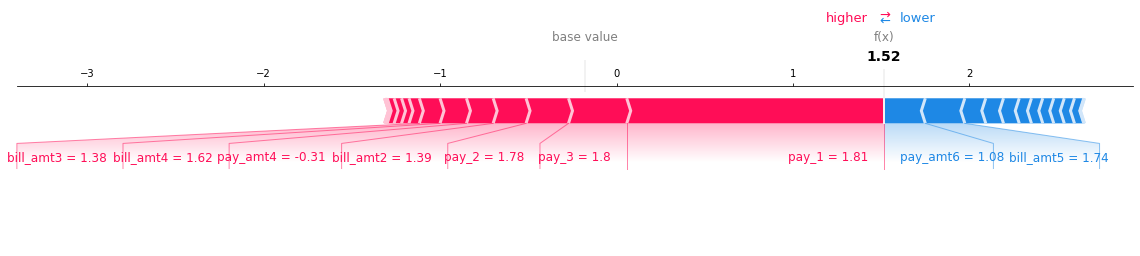

In [28]:
X_train_enc = X_train_enc.round(2)
X_test_enc = X_test_enc.round(2)

shap.force_plot(
    cb_explainer.expected_value,
    test_cb_shap_values[5],
    X_test_enc.iloc[5, :],
    matplotlib=True,
)

Yes, the we feel as the test scores agree with the validation scores since they are almost identical! We fairly trust these results as we don’t think we have to much of an optimization bias as we did explore many models and performed a good amount of hyperparameter tuning.

In the above plot as expected we can see that feature pay_1 is the strongest force and is pushing the prediction to the right of the base value and we are then predicting ‘1’ and this is actually a correct prediction sine this data point actually defaulted.


<br><br>

## 13. Summary of results <a name="13"></a>
<hr>
rubric={reasoning:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

Models Tried| Model Selected | Parameters used | Most important features | Final F1 Score
-----------| ------------|------------|---------------------|--------------|
DummyClassifier <br /> LogisticRegression <br /> RandomForest <br /> CatBoost <br /> SVC| CatBoost |   **class_weights**=[0.25, 0.75] <br /> **max_depth**=5    |  **pay_1**: Repayment status in the most recent month (sept 2005) <br /> **bill_amt1**: Amount to be payed in the most recent month (sept 2005) | 0.543

Out of all what we tested and went through we feel as though we selected the best model and feel confident in its performance. Our final accuracy was about .8 and we feel as though for a first run-through that that is a very good accuracy score to have for our best model. We feel as though the features with the most importance are features that we thought before would have a string impact, so it was good to see out estimates become reality. 

We can firstly try more model types, as we only explored 4. We could also implement feature engineering and create more relevant features. We also feel as though maybe taking care of some of the unknown categories in marriage and education may possibly make these features more important but that is something we would need to explore by cleaning the data differently and starting the whole process over.



<br><br>

## (Optional) 14. Creating a data analysis pipeline <a name="14"></a>
rubric={reasoning:2}

**Your tasks:**
- In 522 you learned how build a reproducible data analysis pipeline. Convert this notebook into scripts and create a reproducible data analysis pipeline with appropriate documentation. 

<br><br>

## (Optional) 15. Your takeaway from the course <a name="15"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

What is your biggest takeaway from this course? 

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

Well done!! Have a great weekend! 

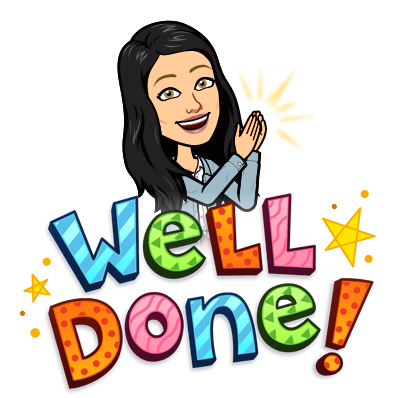

In [29]:
from IPython.display import Image

Image("eva-well-done.png")